**KUDAGO categories relation**

Goal - to estimate relations between different kudago categories.

to do: adjust delimiter for tags, ARL


In [ ]:
#connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read dataset
import pandas as pd
DATA0 = pd.read_csv("/content/drive/My Drive/Multi-scale events detection/kudago/403-497_clean.csv", delimiter=';', encoding='cp1251', error_bad_lines=False)
DATA1 = pd.read_csv("/content/drive/My Drive/Multi-scale events detection/kudago/1-402_clean.csv", delimiter=';', encoding='cp1251', error_bad_lines=False)
DATA2 = pd.read_csv("/content/drive/My Drive/Multi-scale events detection/kudago/497-1653_clean.csv", delimiter=';', encoding='cp1251', error_bad_lines=False)
DATA = pd.concat([DATA0,DATA1,DATA2])

In [ ]:
print('Events amount', DATA.shape[0])

Events amount 165565


#First step: analyzing event tags



# Preprocessing

In [ ]:
#cut the table
df = DATA[['Category', 'Event tag']]

In [ ]:
#checking what kind of categories we have
df.groupby(['Category']).count()


,Event tag
Category,
business-events,476
"business-events,entertainment",6
"business-events,festival",17
"business-events,festival,entertainment",1
"business-events,festival,recreation",1
...,...
"tour,recreation,entertainment",5
"tour,yarmarki-razvlecheniya-yarmarki,entertainment",3
yarmarki-razvlecheniya-yarmarki,5


Firstly, let's not use events of multiple categories


In [ ]:
#checking how many events we have for each category
df_new = df[~df['Category'].str.contains(',', na=False)]
df_new.groupby(['Category']).count()

,Event tag
Category,
business-events,476
cinema,106
concert,56347
education,10641
entertainment,2625
exhibition,15125
fashion,125
festival,4040
holiday,835


In [ ]:
#concatenation of all tags for each category
df_grouped_full = df_new.groupby(['Category']).apply(lambda x: ','.join(x['Event tag']))

In [ ]:
#here we remove categories of kudago, which we will not use for events detecting task
deleted_cats =  ['quest', 'yarmarki-razvlecheniya-yarmarki','other','stock']
df_grouped = df_grouped_full.drop(deleted_cats, axis=0)
df_grouped

Category
business-events    12+,события для бизнеса,события для бизнеса,со...
cinema             кинопоказы,12+,кино (развлечения),кино (развле...
concert            рэп и хип-хоп,концерты,16+,концерты,альтернати...
education          обучение,16+,лучшее,искусство,обучение,12+,рис...
entertainment      игры,развлечения,16+,шоу,лучшее в театрах,разв...
exhibition         выставки,картины, живопись, графика,выставки,к...
fashion            мода и стиль,шоурумы,красота и здоровье,тренин...
festival           фестивали,городские,free,культура и искусство,...
holiday            животные,тематические праздники,выходные,празд...
kids               12+,детские лагеря,лучшее в мае,детям,детские ...
party              18+,танцевальная,вечеринки,электронная музыка,...
photo              животные,фотография,интересное,всей семьей,fre...
recreation         отдых,18+,спорт и фитнес,хоккей,6+,отдых,отдых...
shopping           шопинг (магазины),free,шопинг (магазины),книги...
social-activity    благот

#Summary Table Creation

In [ ]:
#the next cell is very time expensive, we check if we have a file with it
import os
check_file = False
if os.path.exists('/content/drive/My Drive/Colab Notebooks/kudago_tags.pkl'):
  check_file = True
  df_final = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/kudago_tags.pkl')
check_file

True

In [ ]:
#We want to know which tags (rows) were used for which categories (columns) and how many times (data in cells)
#To do it we create DataFrame from the dict of subdicts: one subdict for one category, each subdict maps tag to number of tag's usages 
if check_file == False:
  dict_lists = dict()
  for index in df_grouped.index:
    temp = df_grouped.get(index).rsplit(',')
    one_dict = {i:temp.count(i) for i in temp}
    dict_lists[index]=(one_dict)
  #final statistics DataFrame
  df_final = pd.DataFrame(dict_lists).fillna(0)
else:
  print('File was found')

File was found


In [ ]:
df_final

,business-events,cinema,concert,education,entertainment,exhibition,fashion,festival,holiday,kids,party,photo,recreation,shopping,social-activity,theater,tour
12+,12.0,10.0,10786.0,1526.0,207.0,971.0,4.0,283.0,15.0,36.0,22.0,1.0,210.0,0.0,3.0,3661.0,602.0
события для бизнеса,476.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18+,167.0,67.0,14700.0,1932.0,556.0,401.0,11.0,427.0,39.0,0.0,3527.0,3.0,176.0,0.0,19.0,1978.0,150.0
free,135.0,29.0,2594.0,2681.0,356.0,4051.0,29.0,1653.0,315.0,122.0,1177.0,12.0,348.0,42.0,81.0,435.0,164.0
16+,70.0,11.0,11108.0,2094.0,286.0,454.0,14.0,303.0,9.0,0.0,123.0,0.0,128.0,4.0,7.0,5364.0,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
погода,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
эзотерика,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
блошиные рынки,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ярмарки (развлечения,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#save dataframe to file
if check_file == False:
  df_final.to_pickle("/content/drive/My Drive/Colab Notebooks/kudago_tags.pkl")
else:
  print('File exists')

File exists


#Supervenn visualisation for non-unique tags


In [ ]:
#visualize data with method from https://habr.com/ru/company/yandex/blog/501924/
!pip install supervenn

In [ ]:
#labels are categories
labels = list(df_final.columns)
#sets are tags
sets = []
for index in df_grouped.index:
  temp = df_grouped.get(index).rsplit(',')
  sets.append(set(temp))

In [ ]:
#to find intersections of categories we don't consider unique tags
new_sets = []
for i in range(len(sets)):
  temp_list = []
  for j in range(len(sets)):
    #avoiding comparing with the same set
    if i == j:
      continue
    #we collect not unique tags into list
    temp_list.extend(sets[i] & sets[j])
  #now we need to convert our collection to set
  new_sets.append(set(temp_list))

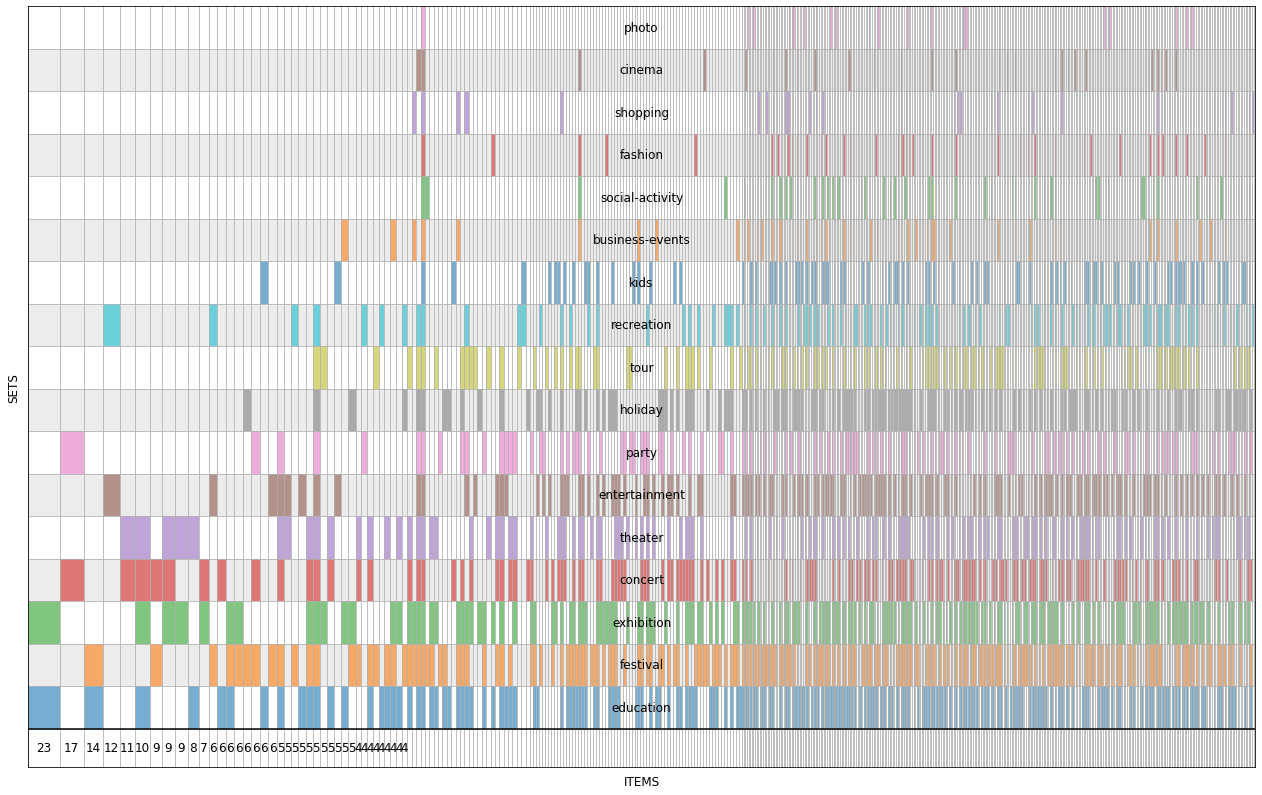

In [ ]:
import matplotlib.pyplot as plt
from supervenn import supervenn
plt.figure(figsize=(22, 14))
visual0 = supervenn(new_sets, labels, side_plots=False, chunks_ordering='size', sets_ordering='size', widths_minmax_ratio=0.05, min_width_for_annotation=4)

# Supervenn visualisation without frequent tags

Results are good, but not so clean, let's firstly delete very frequent tags (appears more than in 5 categories)

In [ ]:
#here we check in how many categories the particular tag appears, and delete very frequent tags
import copy
new_sets_cut = copy.deepcopy(new_sets)

#for all sets
for i in range(len(new_sets)):
  #check all tags
  for j in new_sets[i]:
    counter = 0
    #check for all other sets except the same one
    for k in range(len(new_sets)):
      if k == i:
        continue
      if j in new_sets[k]:
        counter += 1
    if counter > 5:
      new_sets_cut[i].remove(j)

In [ ]:
#amount of unique/not unique tags
print('unique\t common\t total')
for i in range(len(new_sets_cut)):
  print('{}\t :{}\t  :{}\t :{}'.format(len(sets[i])-len(new_sets[i]), len(new_sets[i]), len(sets[i]), labels[i]))

unique	 common	 total
1	 :62	  :63	 :business-events
2	 :35	  :37	 :cinema
47	 :347	  :394	 :concert
41	 :454	  :495	 :education
21	 :300	  :321	 :entertainment
37	 :404	  :441	 :exhibition
3	 :47	  :50	 :fashion
28	 :443	  :471	 :festival
5	 :240	  :245	 :holiday
11	 :148	  :159	 :kids
16	 :243	  :259	 :party
0	 :30	  :30	 :photo
40	 :182	  :222	 :recreation
2	 :41	  :43	 :shopping
3	 :56	  :59	 :social-activity
50	 :301	  :351	 :theater
20	 :205	  :225	 :tour


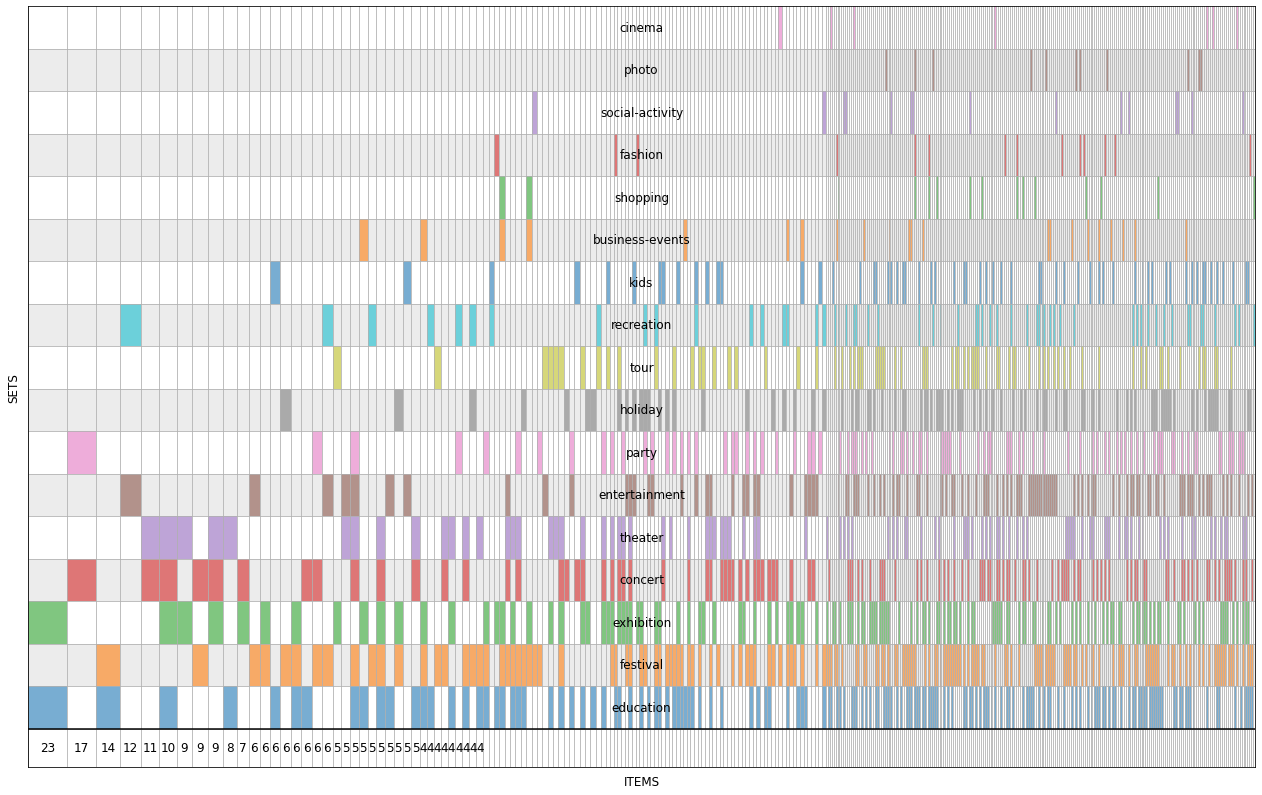

In [ ]:
plt.figure(figsize=(22, 14))
visual = supervenn(new_sets_cut, labels, side_plots=False, chunks_ordering='size', sets_ordering='size', widths_minmax_ratio=0.05, min_width_for_annotation=4)

In [ ]:
#example of extracting common tags
print(visual.chunks[frozenset([labels.index('education'), labels.index('exhibition')])])
print(visual.chunks[frozenset([labels.index('party'), labels.index('concert')])])

{'мэрилин монро', 'акварель', 'эпоха возрождения', 'cобаки', 'аналоговая фотография', 'александр васильев', 'концептуальное искусство', 'абстрактное искусство', 'гравюра', 'мозаика', 'bibliophilia', 'голландия', 'парфюмерия', 'бижутерия', 'архитектура', 'скрапбукинг', 'обучение за рубежом', 'изобретения', 'витражи', 'арт-объекты', 'декупаж', 'батик', 'будущее'}
{'дискотека 90х', 'драм-н-бэйс', 'r&b', 'witch house', 'дискотека 80х', 'glitch', 'рейв', 'виниловые пластинки', 'тяжелый рок', 'душевно', 'хардкор техно', 'эмбиент', 'rnb', 'майкл джексон', 'диско', 'день первокурсника', 'клубная жизнь'}


#Second step: analyzing events of multiple categories

Here we want to analyze which categories have common events (by extracting events with multiple categories)

In [ ]:
df_multiple =  df[df['Category'].str.contains(',', na=False)]
print('Amount of events with multiple categories', df_multiple.shape[0])

Amount of events with multiple categories 41354


In [ ]:
#we create an array of two dims and remeber how many times each category was with another one
n = len(df_grouped_full.index)
group_list = list(df_grouped_full.index)
cats_inter = [[0] * n for i in range(n)]
for event in df_multiple['Category']:
  cats = event.rsplit(',')
  for i in range(len(cats)):
    for j in range(len(cats)):
      if i != j:
        cats_inter[group_list.index(cats[j])][group_list.index(cats[i])] += 1

In [ ]:
df_step2 = pd.DataFrame(cats_inter, columns=group_list, index=group_list).fillna(0)
df_step2 = df_step2.drop(labels=deleted_cats, axis=0)
df_step2 = df_step2.drop(labels=deleted_cats, axis=1)
df_step2

,business-events,cinema,concert,education,entertainment,exhibition,fashion,festival,holiday,kids,party,photo,recreation,shopping,social-activity,theater,tour
business-events,0,0,4,682,29,72,6,51,0,9,2,1,6,1,2,0,1
cinema,0,0,143,683,5634,78,15,1139,60,165,344,3,19,2,26,194,21
concert,4,143,0,1110,1809,137,13,2488,354,1119,1917,5,166,14,288,1111,57
education,682,683,1110,0,1943,674,551,1276,434,2233,476,117,697,58,226,540,368
entertainment,29,5634,1809,1943,0,905,152,3067,977,2147,1229,59,897,272,334,1220,280
exhibition,72,78,137,674,905,0,173,636,97,744,88,447,45,38,182,67,261
fashion,6,15,13,551,152,173,0,93,29,21,40,21,13,91,11,8,2
festival,51,1139,2488,1276,3067,636,93,0,875,1546,674,61,649,44,362,521,174
holiday,0,60,354,434,977,97,29,875,0,1296,687,19,194,57,75,308,126
kids,9,165,1119,2233,2147,744,21,1546,1296,0,154,31,375,34,237,4253,498


We can see a number of events with common categories, but the table does not include total number of events for each category. In other words, if only 1 event of "shopping" out of 1000 is also marked as "business-event" it shows very weak correlation, however, if we have the same result with 1 event of "shopping" out of 2 events it is interesting to know.

In [ ]:
#here we transform our table from 'number' to 'percentege' by taking into account a total number of events for each category
#we divide each column by the number of events and multiply 100 to find a percentege
for cat in df_step2.index:
  count = df[df['Category'].str.contains(cat, na=False)].count()[0]
  df_step2[cat] = df_step2[cat].apply(lambda x: x/count*100)

In [ ]:
#let's highlight large percentege values to see the results better
def style_large_values(v, props=''):
    return props if v > 30 else None
s2 = df_step2.style.applymap(style_large_values, props='color:red;')\
              .applymap(lambda v: 'opacity: 20%;' if (v < 5) else None)
s2

,business-events,cinema,concert,education,entertainment,exhibition,fashion,festival,holiday,kids,party,photo,recreation,shopping,social-activity,theater,tour
business-events,0.000000,0.000000,0.006132,3.461578,0.152768,0.384656,0.561272,0.380370,0.000000,0.074044,0.022696,0.138504,0.127578,0.142248,0.129702,0.000000,0.023602
cinema,0.000000,0.000000,0.219214,3.466653,29.679187,0.416711,1.403181,8.494928,1.355932,1.357466,3.903768,0.415512,0.403997,0.284495,1.686122,0.931573,0.495634
concert,0.314713,2.473620,0.000000,5.633946,9.529579,0.731916,1.216090,18.556086,8.000000,9.206088,21.754426,0.692521,3.529662,1.991465,18.677043,5.334934,1.345291
education,53.658537,11.814565,1.701593,0.000000,10.235474,3.600812,51.543499,9.516706,9.807910,18.371041,5.401725,16.204986,14.820327,8.250356,14.656291,2.593037,8.685391
entertainment,2.281668,97.457187,2.773136,9.861943,0.000000,4.834918,14.218896,22.874403,22.079096,17.663513,13.946891,8.171745,19.072932,38.691323,21.660182,5.858343,6.608449
exhibition,5.664831,1.349248,0.210016,3.420972,4.767423,0.000000,16.183349,4.743437,2.192090,6.120938,0.998638,61.911357,0.956836,5.405405,11.802853,0.321729,6.160019
fashion,0.472069,0.259471,0.019929,2.796670,0.800716,0.924244,0.000000,0.693616,0.655367,0.172768,0.453926,2.908587,0.276419,12.944523,0.713359,0.038415,0.047203
festival,4.012589,19.702474,3.814021,6.476500,16.156561,3.397799,8.699719,0.000000,19.774011,12.719046,7.648661,8.448753,13.799702,6.258890,23.476005,2.501801,4.106679
holiday,0.000000,1.037883,0.542670,2.202822,5.146710,0.518218,2.712816,6.525955,0.000000,10.662279,7.796187,2.631579,4.125027,8.108108,4.863813,1.478992,2.973802
kids,0.708104,2.854177,1.715389,11.333875,11.310120,3.974784,1.964453,11.530430,29.288136,0.000000,1.747617,4.293629,7.973634,4.836415,15.369650,20.422569,11.753599


Now we can easily find some trends:
*   53% events of 'business-events' are also 'education'
*   97% events of 'cinema' are also 'entertainment'
*   61% events of 'photos' are also 'exhibition'
*   and so on.. 

# Third step: Associations rules learning analyzes

ARL basics: one have a collection D = [d_{1}, d_{2}, ..., d_{n}], where d_{i} is a unique transaction-itemset. There are items inside of the each d_{i}, which are represented in binary view. Usually each d_{i} is described with non-zero values (k-itemset). As a result of ARL algorithm applying one can have a rules that represents information about corelation between different items.

Install and prepare algorithms

In [ ]:
#ARL analysis https://habr.com/ru/company/ods/blog/353502/
!pip install apyori 
#- does not work. Out of memory for our data...
import apyori

  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=f0ebe5b90887efe2b54c4802ca028ccea333cd09f56de88298beb8516c4a1931
  Stored in directory: /root/.cache/pip/wheels/cb/f6/e1/57973c631d27efd1a2f375bd6a83b2a616c4021f24aab84080
Successfully built apyori


In [ ]:
#using ECLAT algorithm 
import numpy as np
"""
Класс инициируется 3мя параметрами:
- min_supp - минимальный support  который мы рассматриваем для ItemSet. Рассчитывается как % от количества транзакций
- max_items - максимальное количество елементов в нашем ItemSet
- min_items - минимальное количество элементов ItemSet
"""
class Eclat:
    #инициализация объекта класса
    def __init__(self, min_support = 0.01, max_items = 5, min_items = 2):
        self.min_support = min_support
        self.max_items = max_items
        self.min_items = min_items
        self.item_lst = list()
        self.item_len = 0
        self.item_dict = dict()
        self.final_dict = dict()
        self.data_size = 0
    
    #создание словаря из ненулевых объектов из всех транзакций (вертикальный датасет)
    def read_data(self, dataset):
        for index, row in dataset.iterrows():
            #print('row = ', row[0])
            row_wo_na = set(row[0])
            #print('row = ', row_wo_na)
            for item in row_wo_na:
                #print('item =', item, 'item strip =', item.strip())
                item = str(item)
                item = item.strip()
                #print(item)
                if item in self.item_dict:
                    self.item_dict[item][0] += 1
                else:
                    self.item_dict.setdefault(item, []).append(1)
                self.item_dict[item].append(index)
        #задаем переменные экземпляра (instance variables)
        self.data_size = dataset.shape[0]
        print('data size = ', self.data_size)
        self.item_lst = list(self.item_dict.keys())
        self.item_len = len(self.item_lst)
        self.min_support = self.min_support * self.data_size
        #print ("min_supp", self.min_support)
        
    #рекурсивный метод для поиска всех ItemSet по алгоритму Eclat
    #структура данных: {Item: [Supp number, tid1, tid2, tid3, ...]}
    def recur_eclat(self, item_name, tids_array, minsupp, num_items, k_start):
        if tids_array[0] >= minsupp and num_items <= self.max_items:
            for k in range(k_start+1, self.item_len):
                if self.item_dict[self.item_lst[k]][0] >= minsupp:
                    new_item = item_name + " | " + self.item_lst[k]
                    new_tids = np.intersect1d(tids_array[1:], self.item_dict[self.item_lst[k]][1:])
                    new_tids_size = new_tids.size
                    new_tids = np.insert(new_tids, 0, new_tids_size)
                    if new_tids_size >= minsupp:
                        if num_items >= self.min_items: self.final_dict.update({new_item: new_tids})
                        self.recur_eclat(new_item, new_tids, minsupp, num_items+1, k)
    
    #последовательный вызов функций определенных выше
    def fit(self, dataset):
        i = 0
        self.read_data(dataset)
        for w in self.item_lst:
            self.recur_eclat(w, self.item_dict[w], self.min_support, 2, i)
            if not i%100:
              print(i,'/', len(self.item_lst))
            i+=1
        return self
        
    #вывод в форме словаря {ItemSet: support(ItemSet)}
    def transform(self):
        #return {k: "{0:.4f}%".format((v[0]+0.0)/self.data_size*100) for k, v in self.final_dict.items()}
        return {k: "{0:.4f}".format((v[0]+0.0)/self.data_size) for k, v in self.final_dict.items()}
      
    def to_file(self, path_to_file):
      np.save(path_to_file, self.final_dict)

    #we use dataset to get other fields except final_dict
    def from_file(self, path_to_file, dataset):
      self.read_data(dataset)
      self.final_dict = np.load(path_to_file, allow_pickle = True).item()



Data preparation

In [ ]:
#define function to build tuples with label of category\tag
def isNaN(string):
    return string != string

def make_tuples(event_cats, key):
  new_list = list()
  if isNaN(event_cats):
    return new_list
  for cat in event_cats.split(','):
    new_list.append((cat, key))
  return new_list
  #print(event_cats.split(','), key)


In [ ]:
#tags and tags are items
df['Category'] = df['Category'].apply(make_tuples, args = [1])
df['Category']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0                             [(concert, 1)]
1                               [(stock, 1)]
2                             [(concert, 1)]
3                             [(concert, 1)]
4                             [(concert, 1)]
                         ...                
115695                     [(exhibition, 1)]
115696                     [(exhibition, 1)]
115697                     [(exhibition, 1)]
115698    [(concert, 1), (entertainment, 1)]
115699                     [(exhibition, 1)]
Name: Category, Length: 165565, dtype: object

In [ ]:
df['Event tag'] = df['Event tag'].apply(make_tuples, args = [0])
df['Event tag']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0             [(рэп и хип-хоп, 0), (концерты, 0), (16+, 0)]
1              [(лучшее, 0), (акции и скидки, 0), (16+, 0)]
2         [(концерты, 0), (альтернатива, 0), (инди, 0), ...
3                 [(концерты, 0), (авторская, 0), (18+, 0)]
4         [(12+, 0), (романтичные места и события, 0), (...
                                ...                        
115695             [(выставки, 0), (история и личности, 0)]
115696             [(выставки, 0), (история и личности, 0)]
115697    [(выставки, 0), (архитектура и дизайн, 0), (12...
115698    [(шоу, 0), (петросян, 0), (16+, 0), (концерты,...
115699             [(выставки, 0), (история и личности, 0)]
Name: Event tag, Length: 165565, dtype: object

In [ ]:
df['item'] = df.apply(lambda r: r['Category'] + r['Event tag'], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Tags and categories analysis

In [ ]:
df_tags_and_cats = df.drop(df.columns[[0, 1]], axis=1)
df_tags_and_cats

,item
0,"[(concert, 1), (рэп и хип-хоп, 0), (концерты, ..."
1,"[(stock, 1), (лучшее, 0), (акции и скидки, 0),..."
2,"[(concert, 1), (концерты, 0), (альтернатива, 0..."
3,"[(concert, 1), (концерты, 0), (авторская, 0), ..."
4,"[(concert, 1), (12+, 0), (романтичные места и ..."
...,...
115695,"[(exhibition, 1), (выставки, 0), (история и ли..."
115696,"[(exhibition, 1), (выставки, 0), (история и ли..."
115697,"[(exhibition, 1), (выставки, 0), (архитектура ..."
115698,"[(concert, 1), (entertainment, 1), (шоу, 0), (..."


In [ ]:
model = Eclat(min_support = 0.05, max_items = 3, min_items = 2)

In [ ]:
#~1 mins to calculate
model.fit(df_tags_and_cats)

data size =  165565
0 / 1304
100 / 1304
200 / 1304
300 / 1304
400 / 1304
500 / 1304
600 / 1304
700 / 1304
800 / 1304
900 / 1304
1000 / 1304
1100 / 1304
1200 / 1304
1300 / 1304


In [ ]:
res = model.transform()
sorted_res = sorted(res.items(), key = lambda x: x[1], reverse=True)
sorted_res

[("('concert', 1) | ('концерты', 0)", '0.3474'),
 ("('concert', 1) | ('концерты', 0) | ('18+', 0)", '0.1219'),
 ("('concert', 1) | ('18+', 0)", '0.1219'),
 ("('концерты', 0) | ('18+', 0)", '0.1219'),
 ("('спектакли', 0) | ('theater', 1)", '0.1199'),
 ("('education', 1) | ('обучение', 0)", '0.1147'),
 ("('спектакли', 0) | ('лучшее в театрах', 0)", '0.1111'),
 ("('спектакли', 0) | ('лучшее в театрах', 0) | ('theater', 1)", '0.1111'),
 ("('лучшее в театрах', 0) | ('theater', 1)", '0.1111'),
 ("('entertainment', 1) | ('развлечения', 0)", '0.1091'),
 ("('выставки', 0) | ('exhibition', 1)", '0.1085'),
 ("('concert', 1) | ('концерты', 0) | ('классическая', 0)", '0.1022'),
 ("('concert', 1) | ('классическая', 0)", '0.1022'),
 ("('концерты', 0) | ('классическая', 0)", '0.1022'),
 ("('concert', 1) | ('концерты', 0) | ('6+', 0)", '0.0953'),
 ("('concert', 1) | ('6+', 0)", '0.0953'),
 ("('концерты', 0) | ('6+', 0)", '0.0953'),
 ("('concert', 1) | ('концерты', 0) | ('рок и рок-н-ролл', 0)", '0.0950

Analysis for categories separately

In [ ]:
df_only_cats = df.drop(df.columns[[1, 2]], axis=1)
df_only_cats

,Category
0,"[(concert, 1)]"
1,"[(stock, 1)]"
2,"[(concert, 1)]"
3,"[(concert, 1)]"
4,"[(concert, 1)]"
...,...
115695,"[(exhibition, 1)]"
115696,"[(exhibition, 1)]"
115697,"[(exhibition, 1)]"
115698,"[(concert, 1), (entertainment, 1)]"


In [ ]:
model_cats = Eclat(min_support = 0.01, max_items = 3, min_items = 2)
model_cats.fit(df_only_cats)

data size =  165565
0 / 21


In [ ]:
res_cats = model_cats.transform()
sorted_res_cats = sorted(res_cats.items(), key = lambda x: x[1], reverse=True)
sorted_res_cats

[("('concert', 1) | ('theater', 1)", '0.0378'),
 ("('concert', 1) | ('entertainment', 1)", '0.0364'),
 ("('entertainment', 1) | ('cinema', 1)", '0.0337'),
 ("('concert', 1) | ('festival', 1)", '0.0325'),
 ("('concert', 1) | ('education', 1)", '0.0313'),
 ("('theater', 1) | ('kids', 1)", '0.0295'),
 ("('concert', 1) | ('exhibition', 1)", '0.0269'),
 ("('entertainment', 1) | ('festival', 1)", '0.0233'),
 ("('concert', 1) | ('kids', 1)", '0.0222'),
 ("('concert', 1) | ('stock', 1)", '0.0213'),
 ("('education', 1) | ('entertainment', 1)", '0.0202'),
 ("('theater', 1) | ('entertainment', 1)", '0.0192'),
 ("('concert', 1) | ('party', 1)", '0.0183'),
 ("('entertainment', 1) | ('kids', 1)", '0.0179'),
 ("('education', 1) | ('kids', 1)", '0.0177'),
 ("('entertainment', 1) | ('yarmarki-razvlecheniya-yarmarki', 1)", '0.0161'),
 ("('entertainment', 1) | ('exhibition', 1)", '0.0147'),
 ("('education', 1) | ('festival', 1)", '0.0144'),
 ("('theater', 1) | ('festival', 1)", '0.0136'),
 ("('kids', 1) 

Analysis for tags separately

In [ ]:
df_only_tags = df.drop(df.columns[[0, 2]], axis=1)
df_only_tags

,Event tag
0,"[(рэп и хип-хоп, 0), (концерты, 0), (16+, 0)]"
1,"[(лучшее, 0), (акции и скидки, 0), (16+, 0)]"
2,"[(концерты, 0), (альтернатива, 0), (инди, 0), ..."
3,"[(концерты, 0), (авторская, 0), (18+, 0)]"
4,"[(12+, 0), (романтичные места и события, 0), (..."
...,...
115695,"[(выставки, 0), (история и личности, 0)]"
115696,"[(выставки, 0), (история и личности, 0)]"
115697,"[(выставки, 0), (архитектура и дизайн, 0), (12..."
115698,"[(шоу, 0), (петросян, 0), (16+, 0), (концерты,..."


In [ ]:
model_tags = Eclat(min_support = 0.01, max_items = 3, min_items = 2)
model_tags.fit(df_only_tags)

data size =  165565
0 / 1283
100 / 1283
200 / 1283
300 / 1283
400 / 1283
500 / 1283
600 / 1283
700 / 1283
800 / 1283
900 / 1283
1000 / 1283
1100 / 1283
1200 / 1283


In [ ]:
res_tags = model_tags.transform()
sorted_res_tags = sorted(res_tags.items(), key = lambda x: x[1], reverse=True)
sorted_res_tags

[("('концерты', 0) | ('18+', 0)", '0.1219'),
 ("('спектакли', 0) | ('лучшее в театрах', 0)", '0.1111'),
 ("('концерты', 0) | ('классическая', 0)", '0.1022'),
 ("('концерты', 0) | ('6+', 0)", '0.0953'),
 ("('концерты', 0) | ('рок и рок-н-ролл', 0)", '0.0950'),
 ("('16+', 0) | ('концерты', 0)", '0.0897'),
 ("('концерты', 0) | ('12+', 0)", '0.0873'),
 ("('лучшее', 0) | ('обучение', 0)", '0.0719'),
 ("('классическая', 0) | ('6+', 0)", '0.0622'),
 ("('концерты', 0) | ('классическая', 0) | ('6+', 0)", '0.0620'),
 ("('концерты', 0) | ('поп-музыка', 0)", '0.0587'),
 ("('концерты', 0) | ('джаз и блюз', 0)", '0.0572'),
 ("('концерты', 0) | ('free', 0)", '0.0537'),
 ("('18+', 0) | ('рок и рок-н-ролл', 0)", '0.0525'),
 ("('концерты', 0) | ('18+', 0) | ('рок и рок-н-ролл', 0)", '0.0516'),
 ("('16+', 0) | ('спектакли', 0)", '0.0435'),
 ("('обучение', 0) | ('free', 0)", '0.0421'),
 ("('16+', 0) | ('лучшее в театрах', 0)", '0.0420'),
 ("('18+', 0) | ('free', 0)", '0.0414'),
 ("('16+', 0) | ('спектакли